In [1]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage, struct_tools
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [2]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=False, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [3]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 32
matfile : t150204001_probe1_contact3_unit1.mat


['P1-6-1', 'P2-24-1', 'P1-19-1', 'P1-17-1', 'P1-12-1']

In [4]:
info_session

,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
162,t150204001_chan_01_24_new,1,6,1,8,11,1,"[[123, 128]]"
208,t150204001_chan_25_48_new,2,24,1,5,8,1,"[[129, 139]]"
177,t150204001_chan_01_24_new,1,19,1,1,8,1,None
175,t150204001_chan_01_24_new,1,17,1,1,3,1,None
170,t150204001_chan_01_24_new,1,12,1,1,3,1,None
189,t150204001_chan_25_48_new,2,7,4,8,10,1,"[[123, 128], [170, 173]]"
197,t150204001_chan_25_48_new,2,14,1,3,5,1,None
192,t150204001_chan_25_48_new,2,9,3,1,8,1,None
156,t150204001_chan_01_24_new,1,1,1,5,8,1,"[[132, 139]]"
206,t150204001_chan_25_48_new,2,23,1,1,3,1,None


In [5]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

### Format spike times 

In [6]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [7]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [354096 355172 356491 357799 359134 360433 361087]
times as neo events : [354096. 355172. 356491. 357799. 359134. 360433. 361087.] ms
spike train sample : [    334    5067    6996 ... 3658225 3659812 3660582]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [8]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


### Format target

In [9]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [10]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

# Raster plot

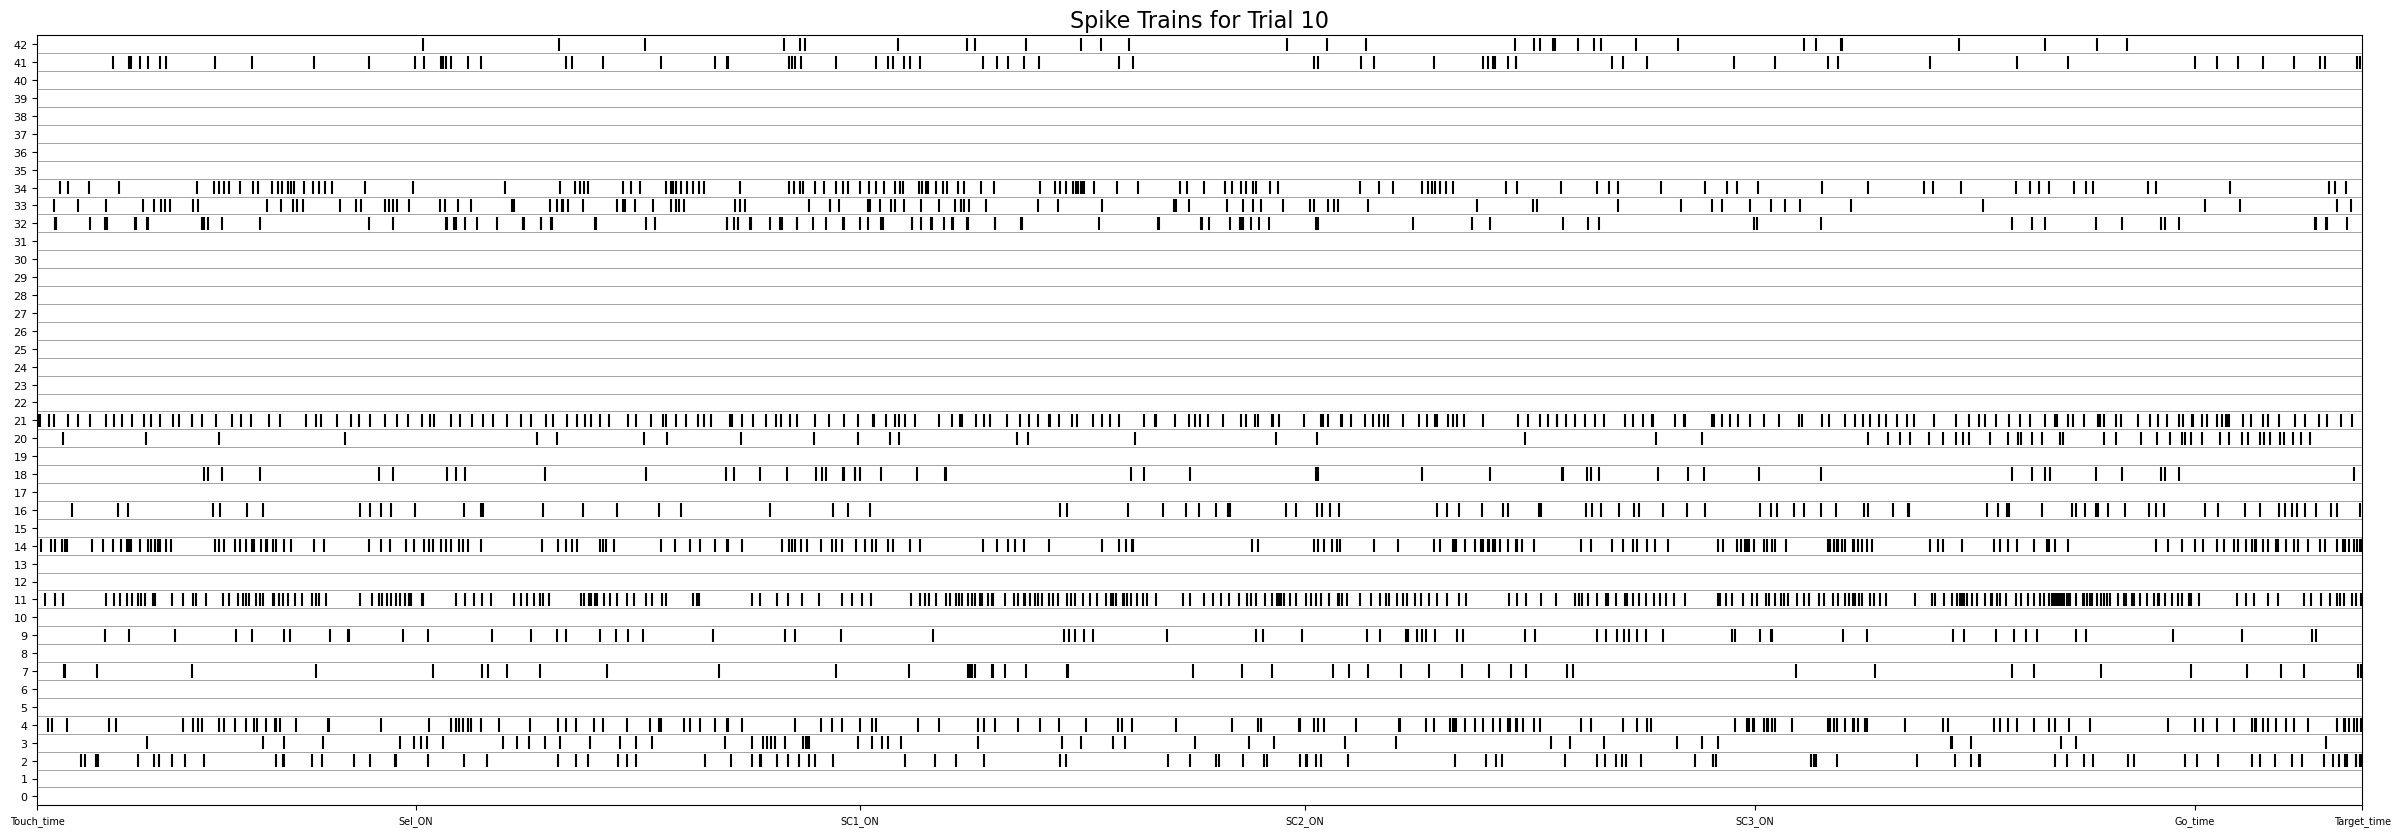

In [11]:
n_neurons = spikes_times_aligned.shape[0]
n_trials = spikes_times_aligned.shape[1]

t = 10
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


## Stable neurons exctraction

In [12]:
spk_count = np.zeros((n_neurons, n_trials))
spk_count.shape

(43, 176)

In [13]:
# get spike count for each neuron by trials

def get_spk_count(spikes_times_aligned):
    for n in range(n_neurons) : 
        for t in range(n_trials) : 
            spk_count_trial = spikes_times_aligned[n][t]['spike_time']
            spk_count_trial = spk_count_trial[spk_count_trial != 0]
            spk_count[n, t] = spk_count_trial.shape[0]

    return spk_count

In [14]:
spk_count = get_spk_count(spikes_times_aligned)

In [15]:
spk_count[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  9.,
       15., 17., 15., 15., 13., 15., 17., 18., 12., 14., 15., 16., 21.,
       17., 12.,  9., 13.,  8., 23., 15., 17., 17., 22., 23., 19., 19.,
       12.,  9., 15., 20., 19., 14., 21., 20., 10.,  8., 17., 18., 10.,
       15., 13., 17.,  4., 12., 13., 11.])

In [16]:
spikes_times_aligned[0][0]['unit_label']

'P1-6-1'

/tmp/ipykernel_13556/448616982.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


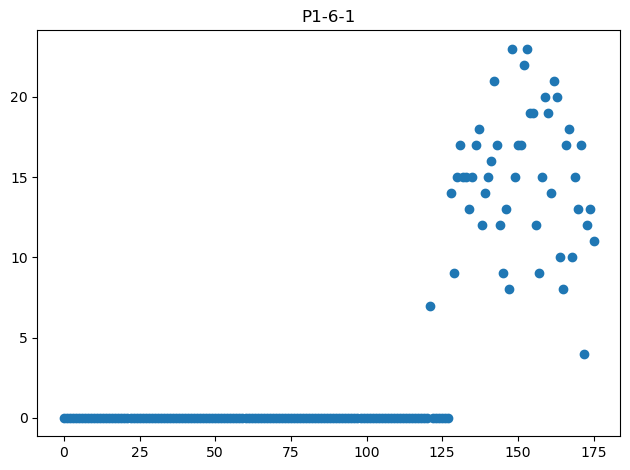

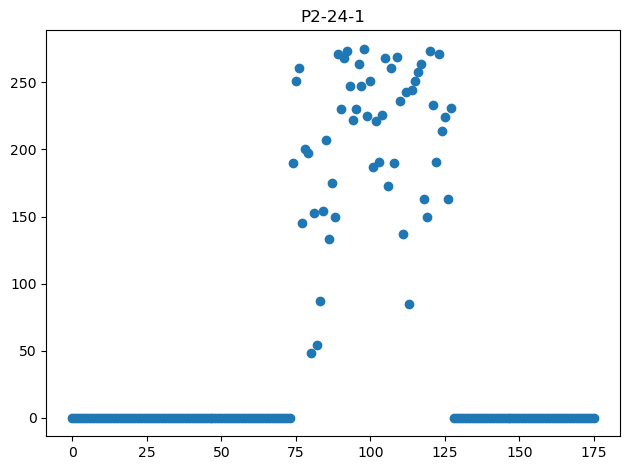

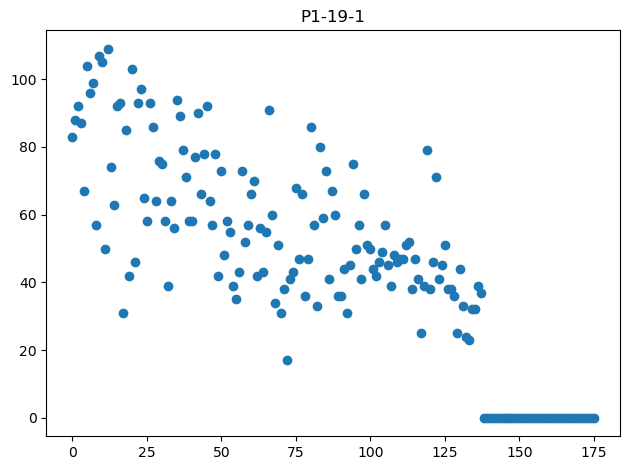

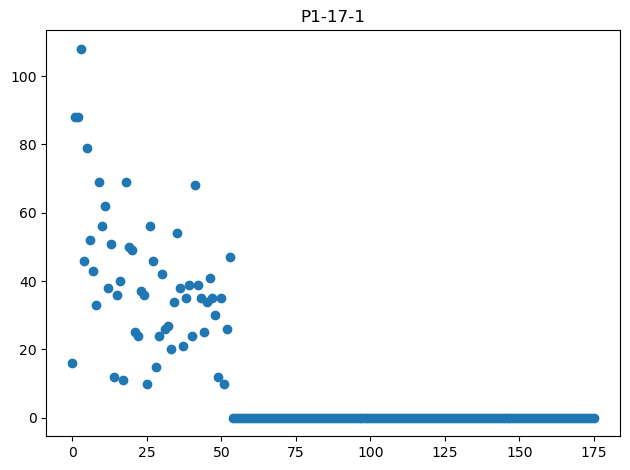

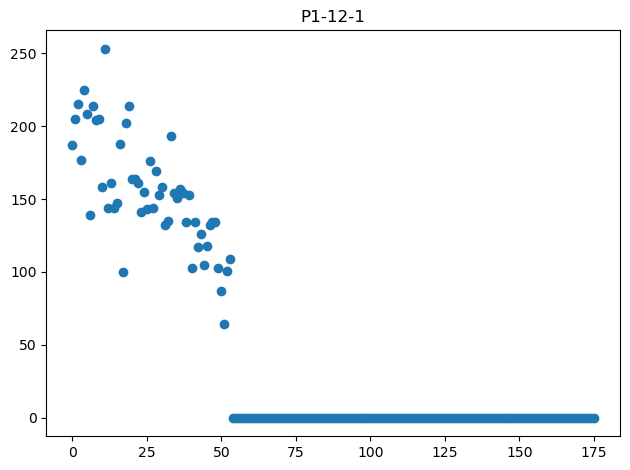

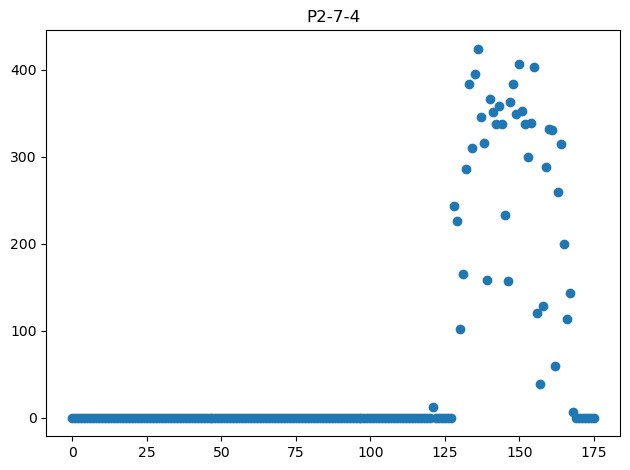

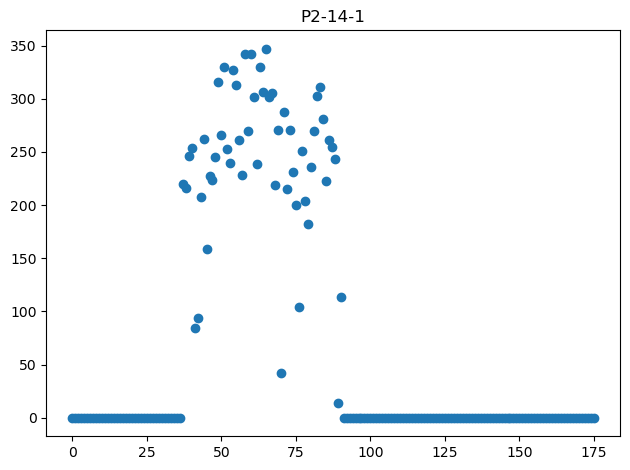

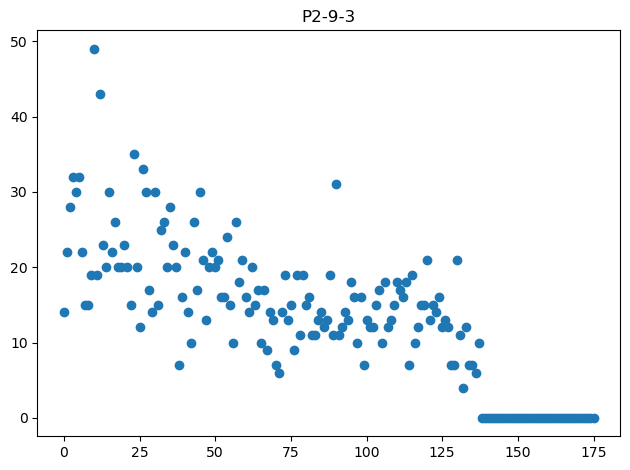

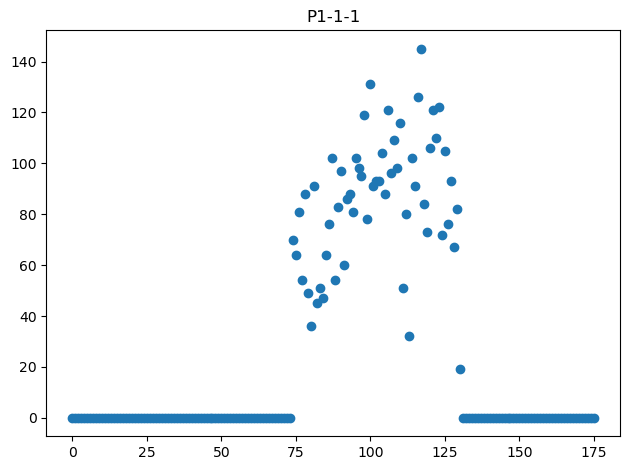

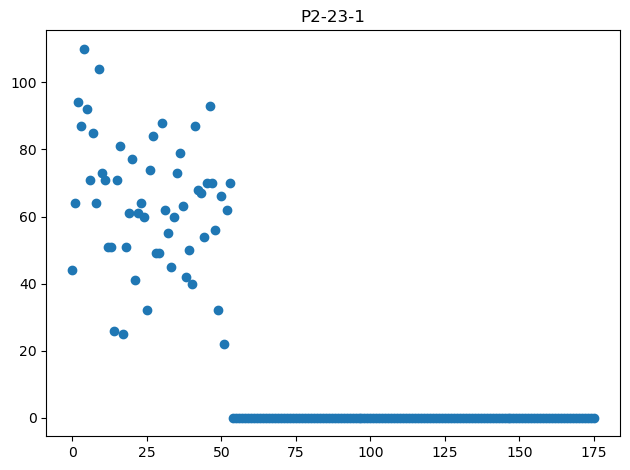

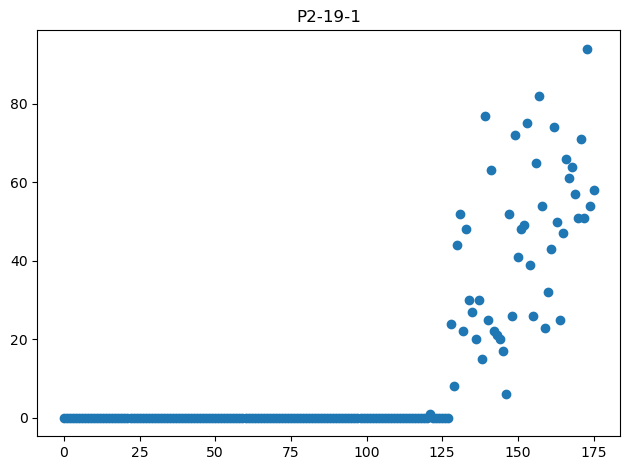

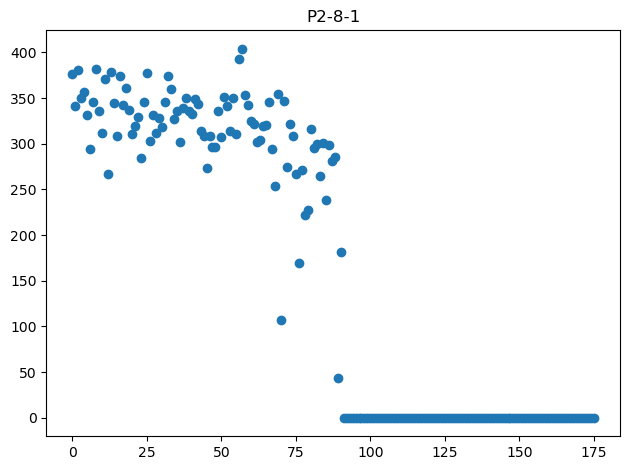

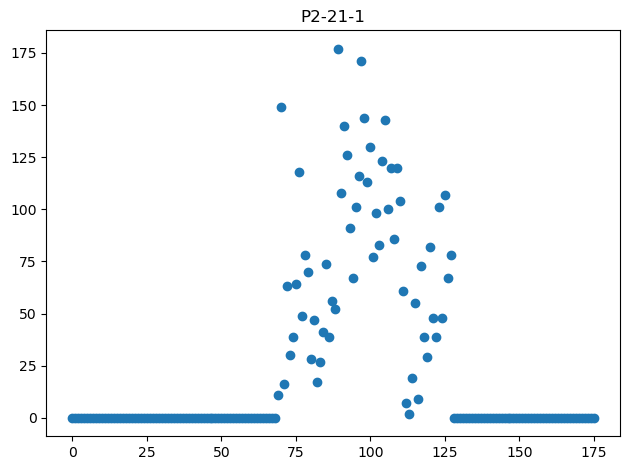

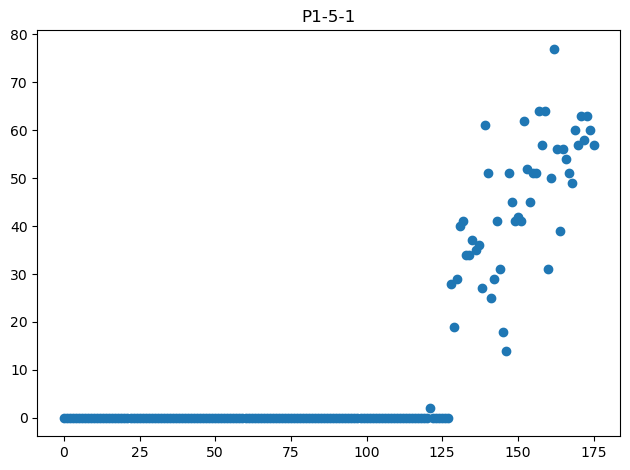

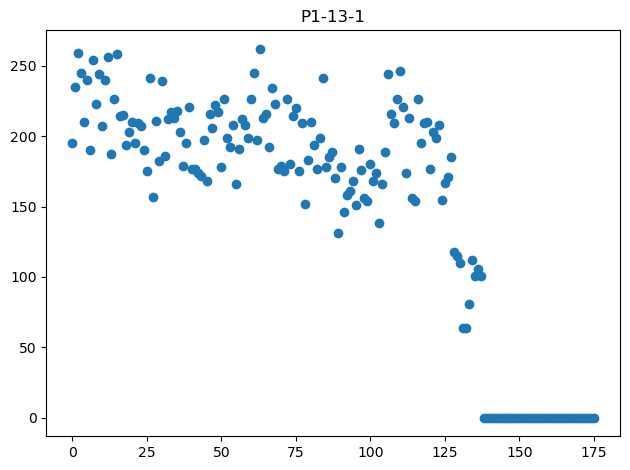

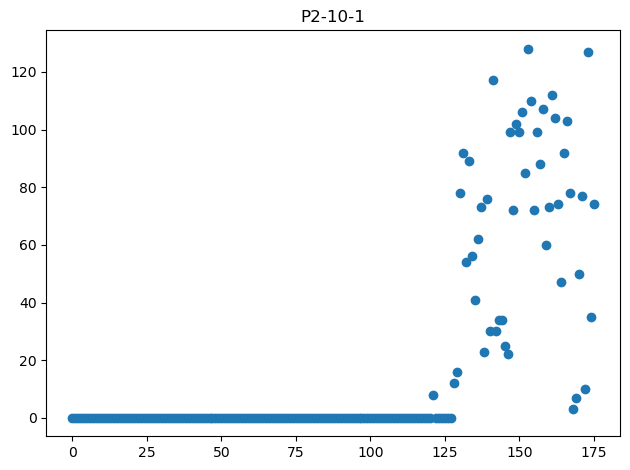

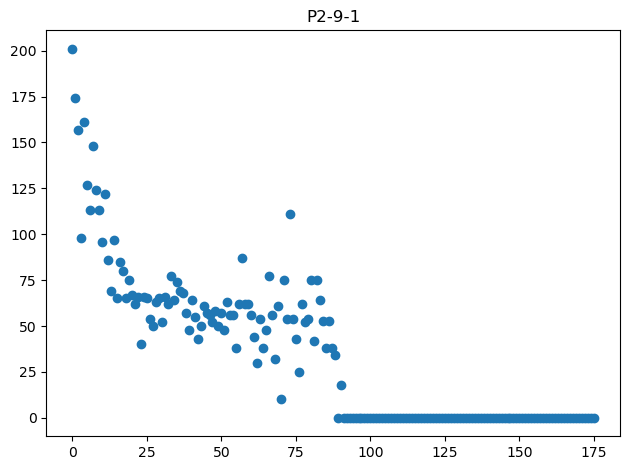

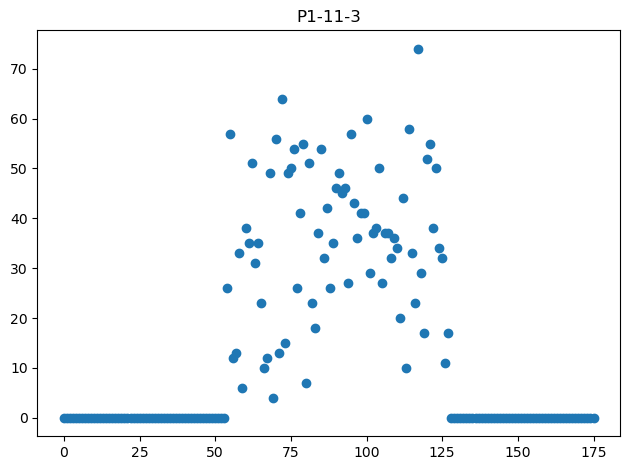

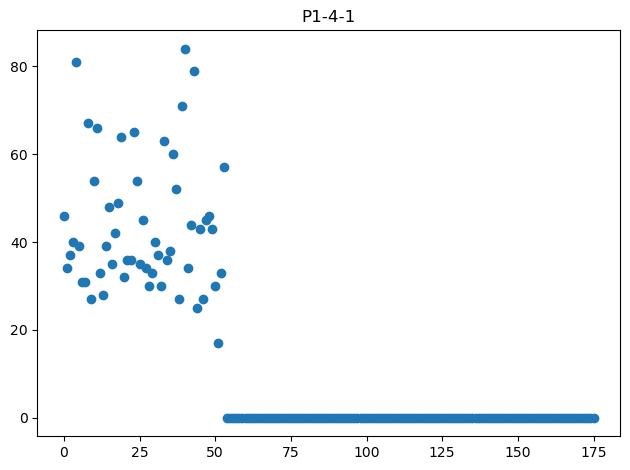

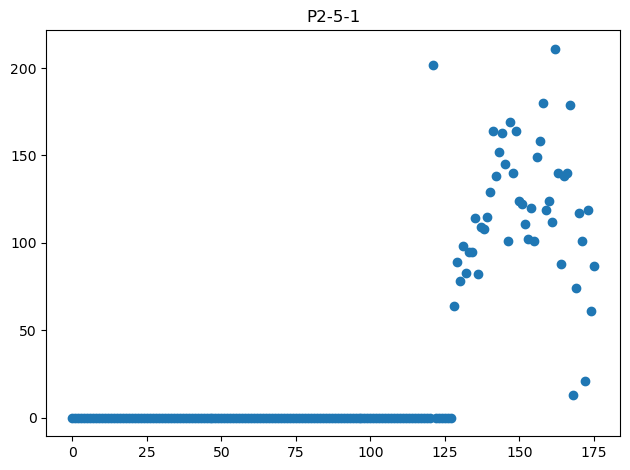

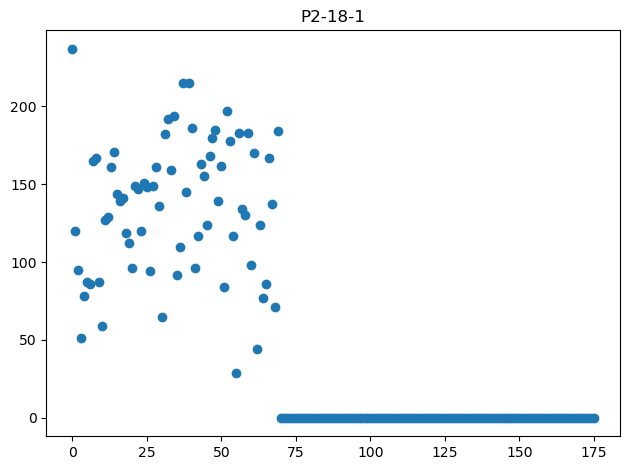

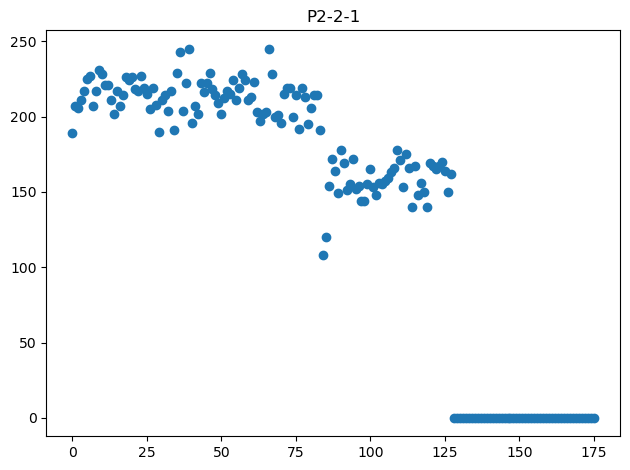

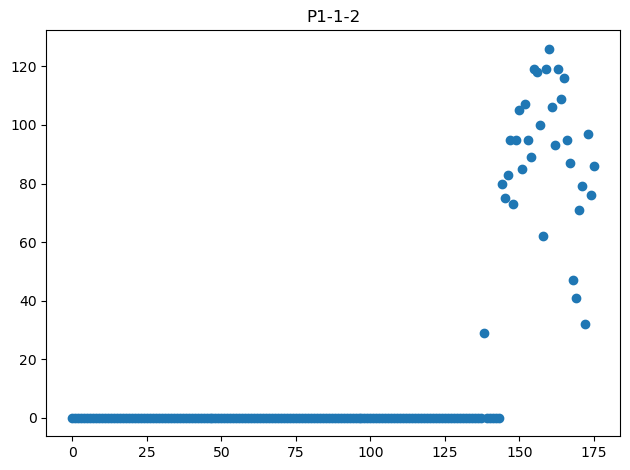

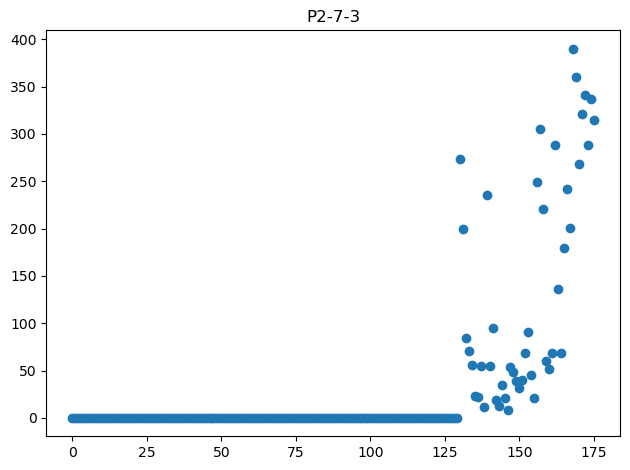

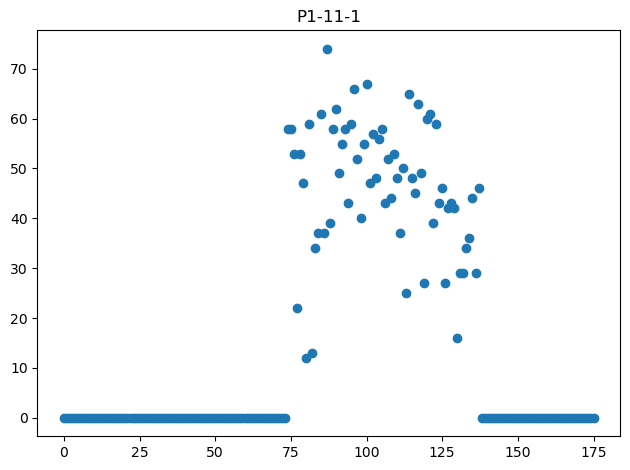

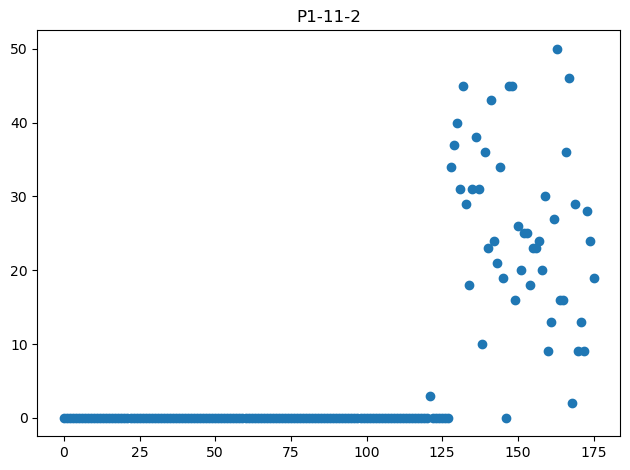

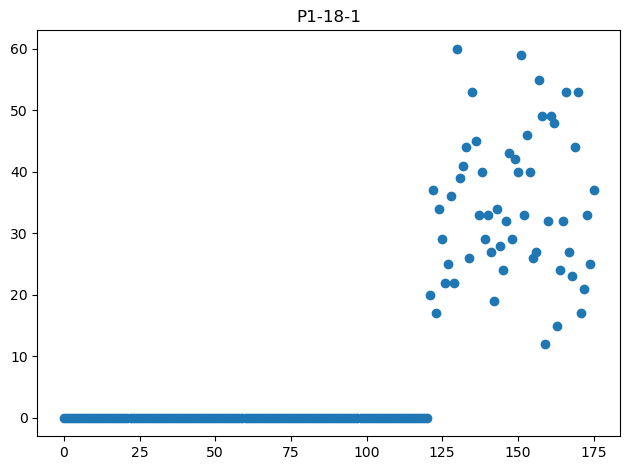

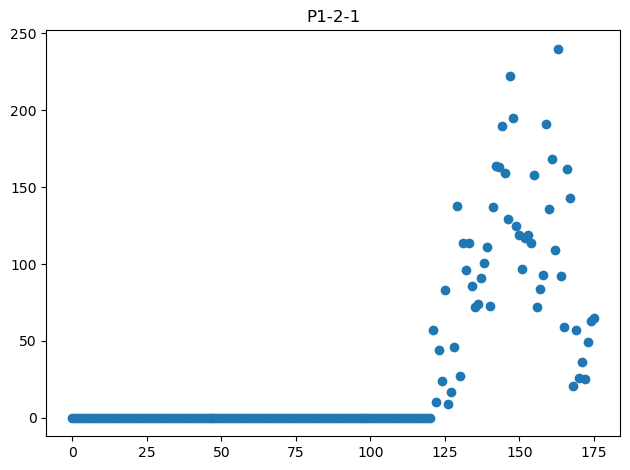

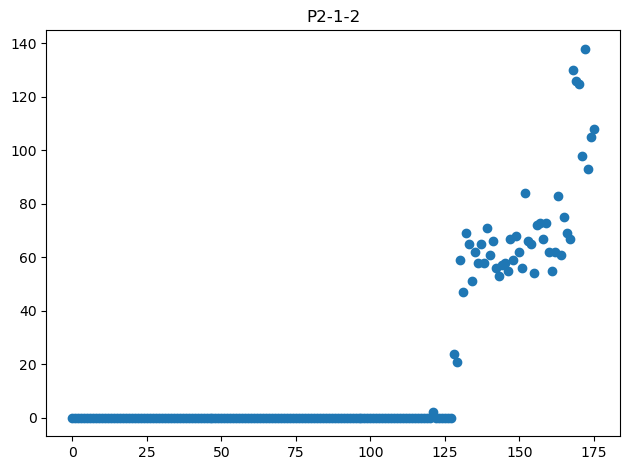

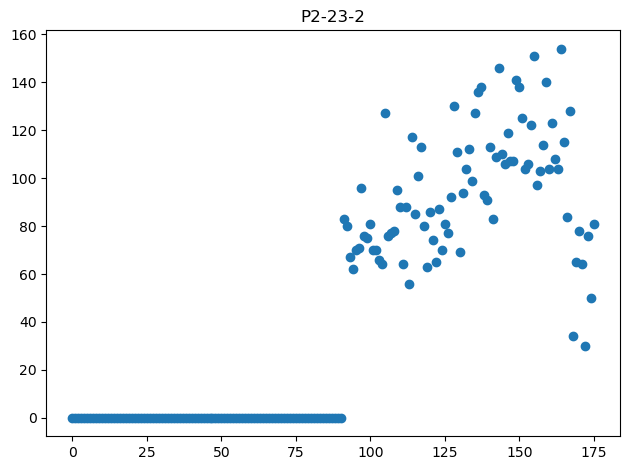

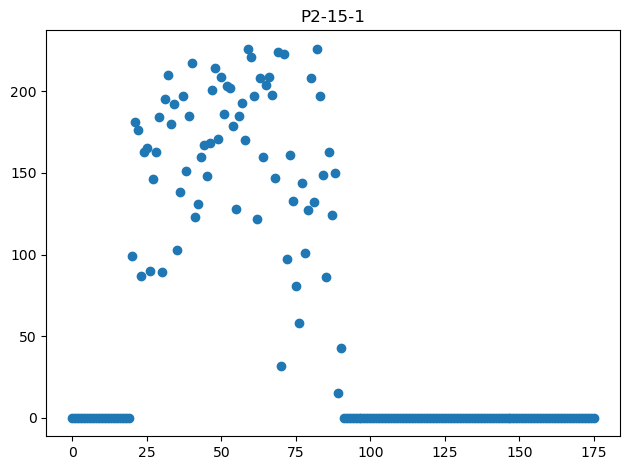

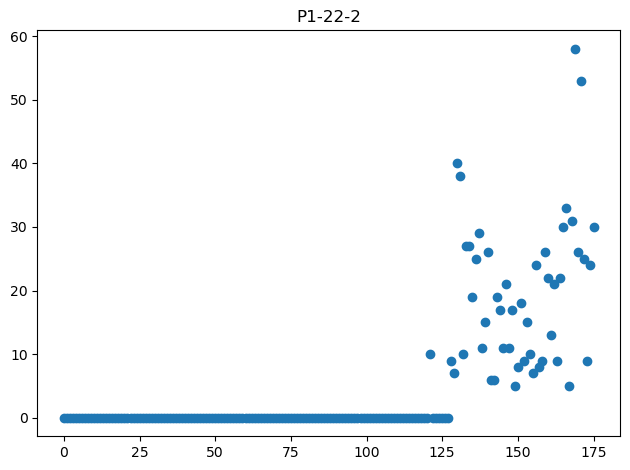

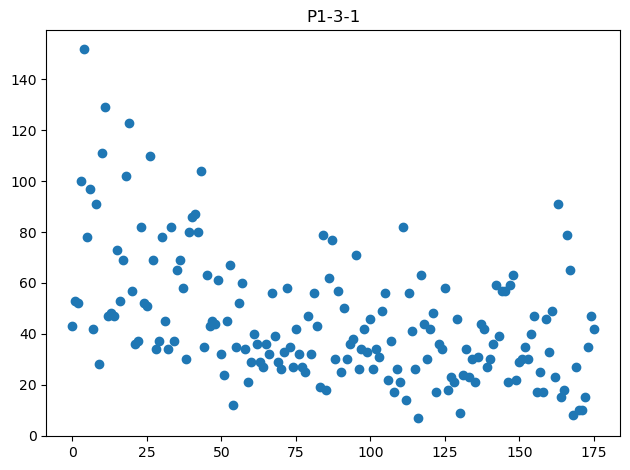

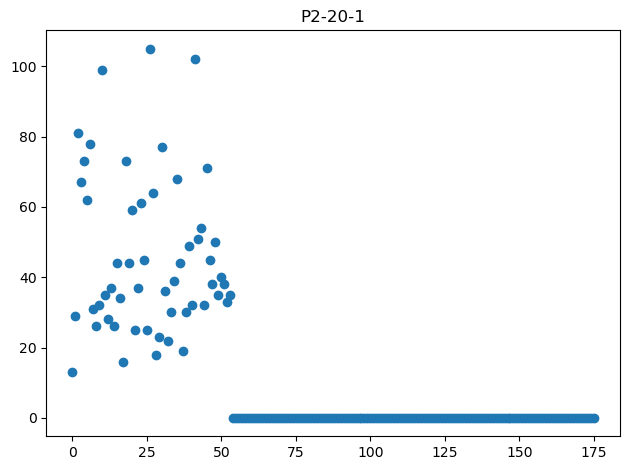

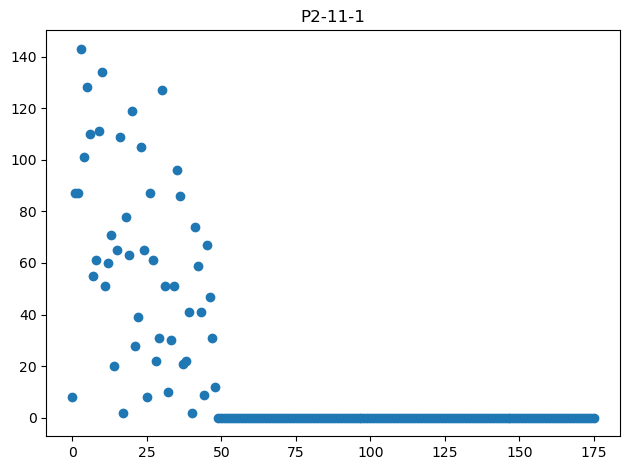

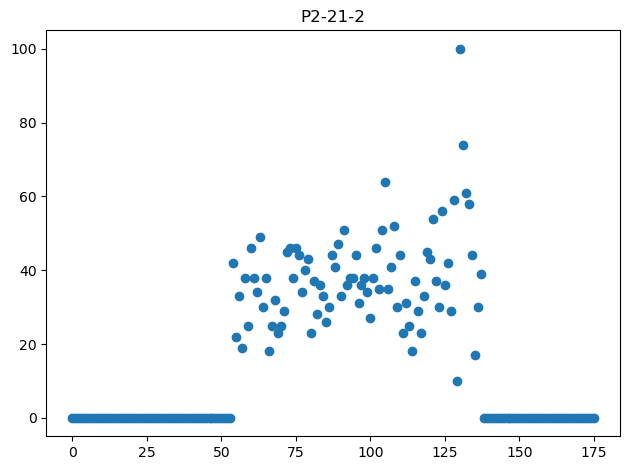

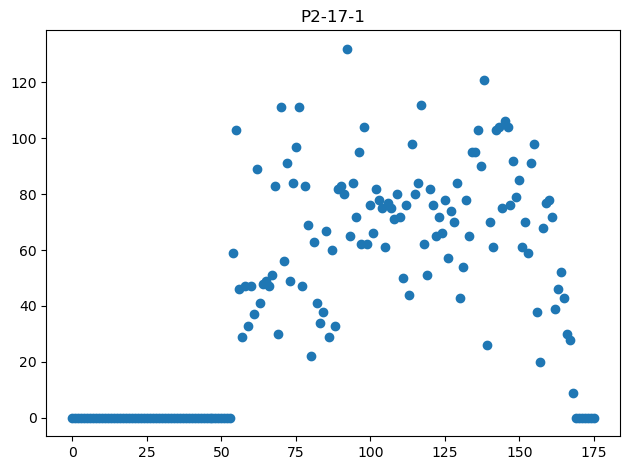

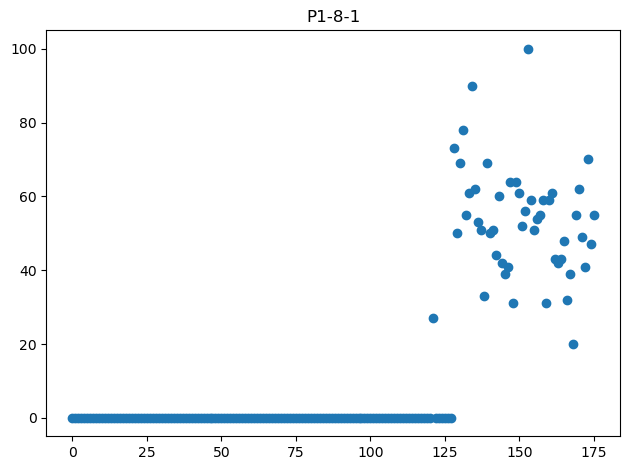

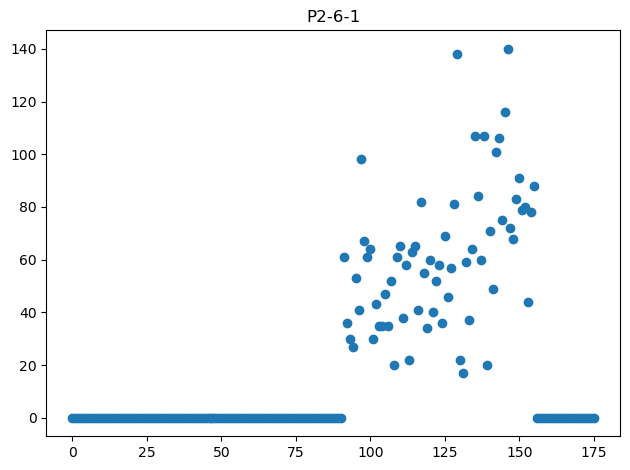

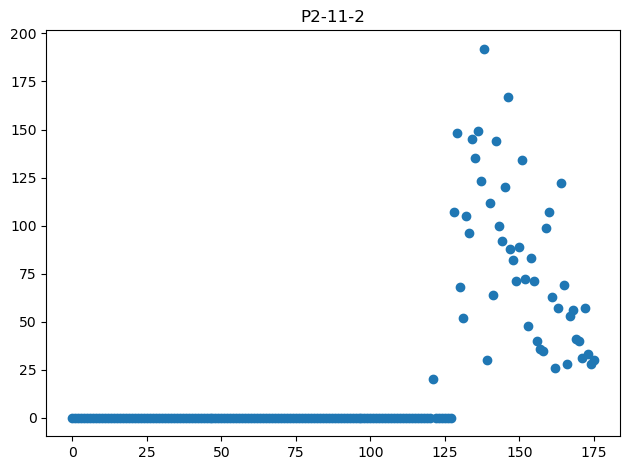

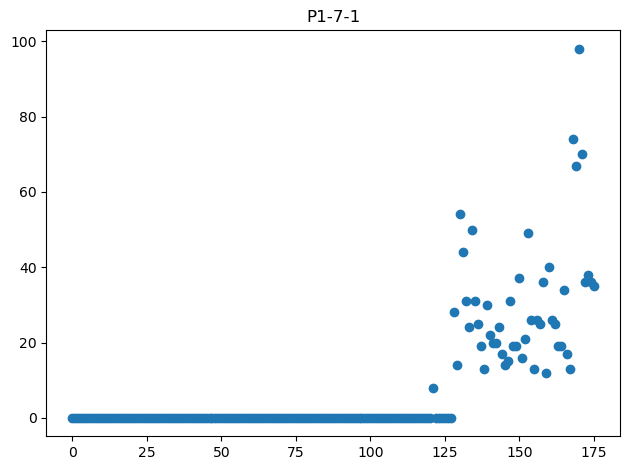

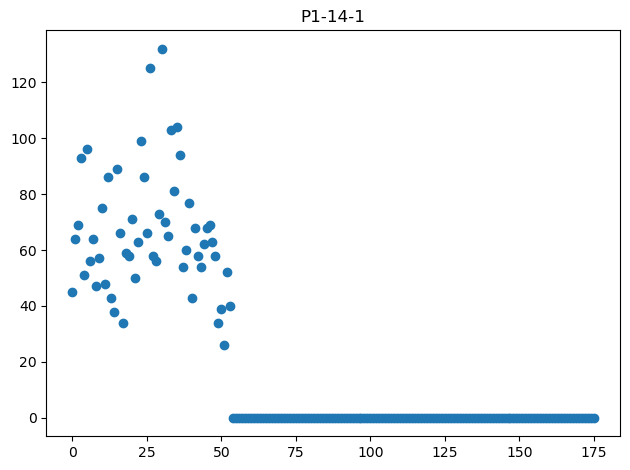

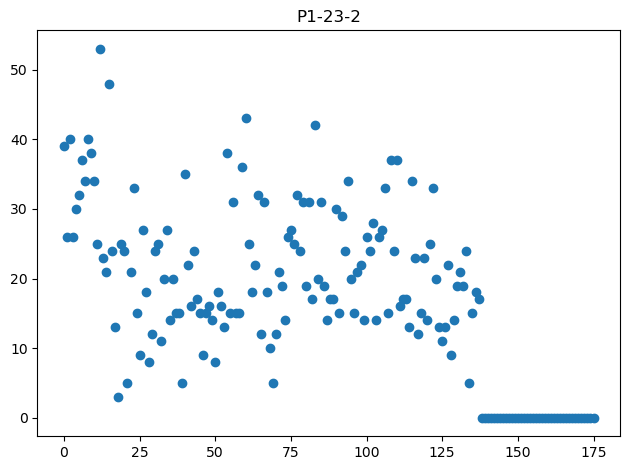

In [17]:
for i in range(n_neurons) :
    plt.figure() 
    plt.scatter(np.arange(0,176), spk_count[i,:])
    plt.title(spikes_times_aligned[i][0]['unit_label'])
    plt.tight_layout()

## High frequency neurons exctraction

In [18]:
n_high = [8,13,14,16,36,37,38,39,41]
n_high = [2,16,27,38,39]
n_high = [1,6,7,10,11,12,20,21,23,25,29,30,31,35,40]


In [19]:
spikes_times_aligned[6][0]['unit_label']

'P2-14-1'

In [20]:
import numpy as np

def get_spike_times_vect(spikes_times_aligned):
    n_trials = spikes_times_aligned.shape[1]
    n_neurons = len(n_high)
    spk_times = np.zeros((n_trials, n_neurons), dtype=object)
    last_spike = np.full((n_trials, n_neurons), np.nan)

    for n_idx, n  in enumerate(n_high):
        print(n)
        for t in range(n_trials):
            if (spikes_times_aligned[n][t]['spike_time'].size > 0) and (spikes_times_aligned[n][t]['spike_time'][0] != 0):
                spk_times[t, n_idx] = spikes_times_aligned[n][t]['spike_time']
                last_spike[t, n_idx] = spikes_times_aligned[n][t]['spike_time'].max()
            else:
                # Handle the case when the array is empty
                spk_times[t, n_idx] = np.full(1, -1)
                last_spike[t, n_idx] = np.array(-1)  # Or any other value you deem appropriate

    # Concatenate while preserving NaN values
    concatenated_spk_times = []
    for spk_time in spk_times.flatten():
        if isinstance(spk_time, np.ndarray):
            concatenated_spk_times.extend(spk_time)
        else:
            concatenated_spk_times.append(np.array(np.nan))

    return np.array(concatenated_spk_times), last_spike, spk_times


In [21]:
spike_times_vec, last_spikes, spk_ts = get_spike_times_vect(spikes_times_aligned)

1
6
7
10
11
12
20
21
23
25
29
30
31
35
40


In [22]:
spk_ts.shape

(176, 15)

In [23]:
epochs = struct_tools.create_epochs(spikes_times_aligned)
channels = np.arange(0, len(n_high))

In [24]:
channels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [25]:
ii_spike_times = np.zeros((len(epochs), len(channels), 2), dtype=int)

start_idx = 0
for epoch_idx, epoch in enumerate(epochs):
    for channel_idx, channel in enumerate(channels):
        ii_spike_times[epoch_idx, channel_idx, 0] = start_idx
        stop_idx = start_idx + spk_ts[epoch_idx,channel_idx].shape[0]
        ii_spike_times[epoch_idx, channel_idx, 1] = stop_idx
        start_idx = stop_idx

In [26]:
print ("ii_spike_times.shape", ii_spike_times.shape)
print ("# epochs =", ii_spike_times.shape[0])
print ("# neurons =",ii_spike_times.shape[1])

ii_spike_times.shape (176, 15, 2)
# epochs = 176
# neurons = 15


# SpikeShip Demo

In [27]:
from spikeship import spikeship, tools

/home/laurie/anaconda3/envs/env_classif/lib/python3.11/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/laurie/Bureau/pattern_classification_git/pipeline_drafts/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [28]:
%%time
spike_times = spike_times_vec
epoch_labels = target_info[completeUnit][1]['Trial_type']
spikeship_diss = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 2.38 s, sys: 0 ns, total: 2.38 s
Wall time: 474 ms


In [29]:
si = np.concatenate([np.arange(epoch_labels.size)[epoch_labels==i+1] for i in range(3)])
indices_tries = np.argsort(epoch_labels)
print("Indices triés:", indices_tries)

# Utilisez ces indices pour obtenir le tableau trié
epoch_labels_tries = epoch_labels[indices_tries]
print("Tableau trié:", epoch_labels_tries)

Indices triés: [  0  68  67  66  65  64  63  62  61  60  59  58  57  56  55  54  69 106
  70  72 107 108 109 110 111 112 113 114 115 116 117 118 119 120  73  71
 156 105 169  18  19  15 171 170 157 168 167 166 165 164 163 162 161  17
 160  14   1   2   3   4   5   6 159 158   8   9  10  11  12  13   7  16
 121 137 172 136 135 134 133 132 131 173 129 127 126 125 124 123 122 128
 130  87 175  83  82  81  80  78  77  84  76  74  32  33  34  35  36  75
  85  79 174  20  86  22  23  24  25  26  27  21  29  30  31  90  89  88
  28 144 145 146 147 148 149 153 151 152 154 155  37 143 150 142  92 140
  93  94  95  96  97  98  99 100 101 102 103 104  53  52 141  51  49  48
  47  46  45  44  43  91  41  40  39  38 138 139  50  42]
Tableau trié: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

([<matplotlib.axis.YTick at 0x75d7f9156a50>,
 [Text(0, 0, '1'),
  Text(0, 18, '1'),
  Text(0, 36, '1'),
  Text(0, 54, '1'),
  Text(0, 72, '2'),
  Text(0, 90, '2'),
  Text(0, 108, '2'),
  Text(0, 126, '2'),
  Text(0, 144, '3'),
  Text(0, 162, '3')])

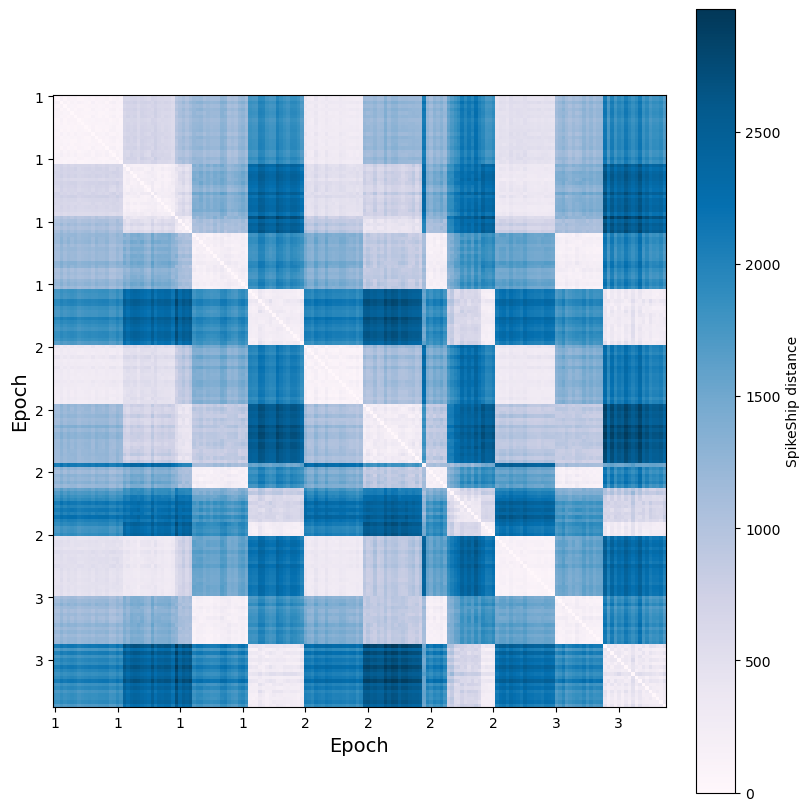

In [30]:
alpha = 0.5; marker = 'o';

# true labels sorting
si = np.concatenate([np.arange(epoch_labels.size)[epoch_labels==i+1] for i in range(3)])
plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss[si,:][:, si], cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,175, 18), epoch_labels[si][::18])
plt.yticks(np.arange(0,175, 18), epoch_labels[si][::18])

([<matplotlib.axis.YTick at 0x75d7f8f39a50>,
 [Text(0, 0, '1'),
  Text(0, 3, '1'),
  Text(0, 6, '1'),
  Text(0, 9, '1'),
  Text(0, 12, '1'),
  Text(0, 15, '1'),
  Text(0, 18, '1'),
  Text(0, 21, '2'),
  Text(0, 24, '2'),
  Text(0, 27, '2'),
  Text(0, 30, '2'),
  Text(0, 33, '2'),
  Text(0, 36, '2'),
  Text(0, 39, '3'),
  Text(0, 42, '3'),
  Text(0, 45, '3'),
  Text(0, 48, '3'),
  Text(0, 51, '3'),
  Text(0, 54, '1'),
  Text(0, 57, '1'),
  Text(0, 60, '1'),
  Text(0, 63, '1'),
  Text(0, 66, '1'),
  Text(0, 69, '1'),
  Text(0, 72, '1'),
  Text(0, 75, '2'),
  Text(0, 78, '2'),
  Text(0, 81, '2'),
  Text(0, 84, '2'),
  Text(0, 87, '2'),
  Text(0, 90, '2'),
  Text(0, 93, '3'),
  Text(0, 96, '3'),
  Text(0, 99, '3'),
  Text(0, 102, '3'),
  Text(0, 105, '1'),
  Text(0, 108, '1'),
  Text(0, 111, '1'),
  Text(0, 114, '1'),
  Text(0, 117, '1'),
  Text(0, 120, '1'),
  Text(0, 123, '2'),
  Text(0, 126, '2'),
  Text(0, 129, '2'),
  Text(0, 132, '2'),
  Text(0, 135, '2'),
  Text(0, 138, '3'),
  Text

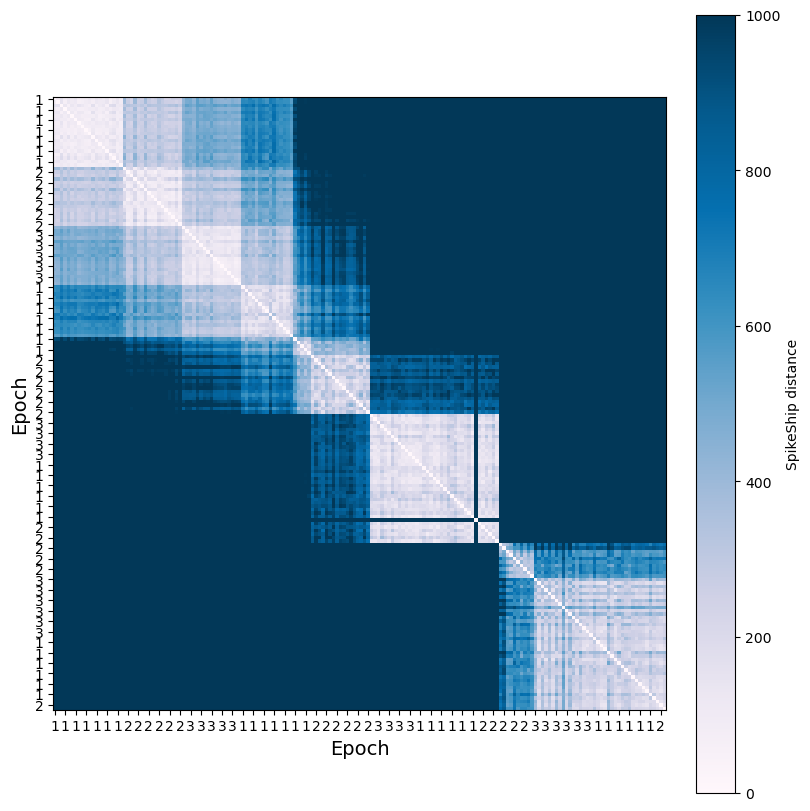

In [31]:
alpha = 0.5; marker = 'o';

# true labels sorting
si = np.concatenate([np.arange(epoch_labels.size)[epoch_labels==i+1] for i in range(3)])
plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss, cmap='PuBu', vmax=1000)
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,175, 3), epoch_labels[::3])
plt.yticks(np.arange(0,175, 3), epoch_labels[::3])

In [32]:
print(epoch_labels_tries)
print(epoch_labels[si])
print(si)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 156 157 158 159 160 161 162 163 164 165 166 167 168 169 

([<matplotlib.axis.YTick at 0x75d7f7b2c950>,
 [Text(0, 0, '1'),
  Text(0, 1, '1'),
  Text(0, 2, '1'),
  Text(0, 3, '1'),
  Text(0, 4, '1'),
  Text(0, 5, '1'),
  Text(0, 6, '1'),
  Text(0, 7, '1'),
  Text(0, 8, '1'),
  Text(0, 9, '1'),
  Text(0, 10, '1'),
  Text(0, 11, '1'),
  Text(0, 12, '1'),
  Text(0, 13, '1'),
  Text(0, 14, '1'),
  Text(0, 15, '1'),
  Text(0, 16, '1'),
  Text(0, 17, '1'),
  Text(0, 18, '1'),
  Text(0, 19, '1'),
  Text(0, 20, '2'),
  Text(0, 21, '2'),
  Text(0, 22, '2'),
  Text(0, 23, '2'),
  Text(0, 24, '2'),
  Text(0, 25, '2'),
  Text(0, 26, '2'),
  Text(0, 27, '2'),
  Text(0, 28, '2'),
  Text(0, 29, '2'),
  Text(0, 30, '2'),
  Text(0, 31, '2'),
  Text(0, 32, '2'),
  Text(0, 33, '2'),
  Text(0, 34, '2'),
  Text(0, 35, '2'),
  Text(0, 36, '2'),
  Text(0, 37, '3'),
  Text(0, 38, '3'),
  Text(0, 39, '3'),
  Text(0, 40, '3'),
  Text(0, 41, '3'),
  Text(0, 42, '3'),
  Text(0, 43, '3'),
  Text(0, 44, '3'),
  Text(0, 45, '3'),
  Text(0, 46, '3'),
  Text(0, 47, '3'),
  Tex

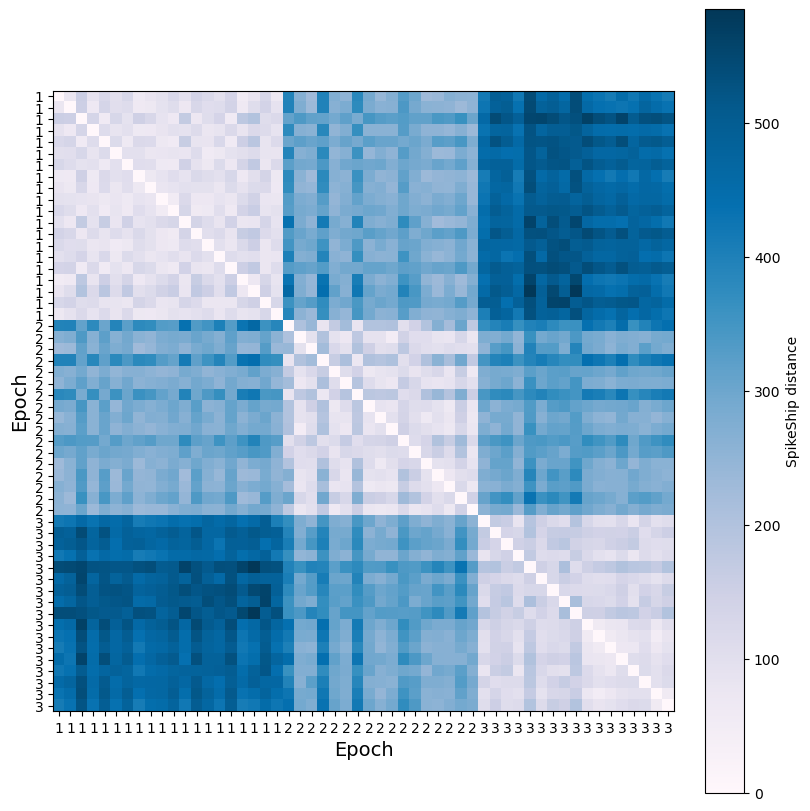

In [33]:
alpha = 0.5; marker = 'o';

# true labels sorting
#si = np.argsort(epoch_labels)

plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss[:54,:][:,:54], cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,54), epoch_labels[:54])
plt.yticks(np.arange(0,54), epoch_labels[:54])

([<matplotlib.axis.YTick at 0x75d802be67d0>,
 [Text(0, 0, '2'),
  Text(0, 1, '2'),
  Text(0, 2, '2'),
  Text(0, 3, '2'),
  Text(0, 4, '2'),
  Text(0, 5, '2'),
  Text(0, 6, '2'),
  Text(0, 7, '2'),
  Text(0, 8, '2'),
  Text(0, 9, '2'),
  Text(0, 10, '2'),
  Text(0, 11, '2'),
  Text(0, 12, '2'),
  Text(0, 13, '2'),
  Text(0, 14, '2'),
  Text(0, 15, '2'),
  Text(0, 16, '3'),
  Text(0, 17, '3'),
  Text(0, 18, '3'),
  Text(0, 19, '3'),
  Text(0, 20, '3'),
  Text(0, 21, '3'),
  Text(0, 22, '3'),
  Text(0, 23, '3'),
  Text(0, 24, '3'),
  Text(0, 25, '3'),
  Text(0, 26, '3'),
  Text(0, 27, '3'),
  Text(0, 28, '3'),
  Text(0, 29, '3'),
  Text(0, 30, '3'),
  Text(0, 31, '3'),
  Text(0, 32, '3'),
  Text(0, 33, '3'),
  Text(0, 34, '1'),
  Text(0, 35, '1'),
  Text(0, 36, '1'),
  Text(0, 37, '1'),
  Text(0, 38, '1'),
  Text(0, 39, '1'),
  Text(0, 40, '1'),
  Text(0, 41, '1'),
  Text(0, 42, '1'),
  Text(0, 43, '1'),
  Text(0, 44, '1'),
  Text(0, 45, '1'),
  Text(0, 46, '1'),
  Text(0, 47, '1'),
  Tex

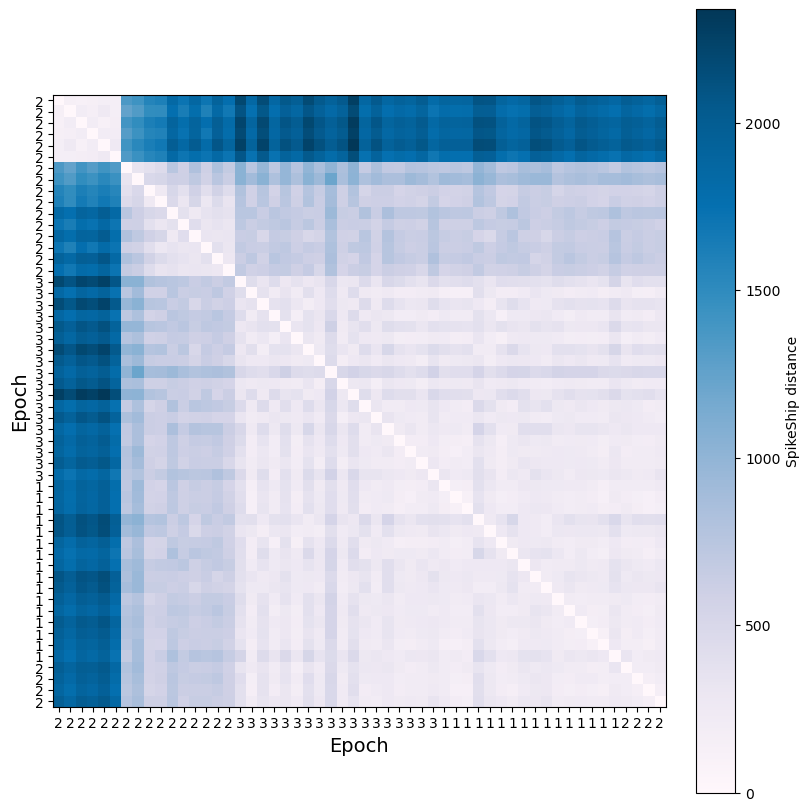

In [34]:
alpha = 0.5; marker = 'o';

# true labels sorting
#si = np.argsort(epoch_labels)

plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss[-54:,:][:,-54:], cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,54), epoch_labels[-54:])
plt.yticks(np.arange(0,54), epoch_labels[-54:])

### Visualization of clusters by using SPOTDis and SpikeShip dissimilarity measures

In [35]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import hdbscan
from sklearn.manifold import TSNE

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
ss_dis_labels = clusterer.fit_predict(spikeship_diss)

print(len(np.unique(ss_dis_labels)), 'clusters found (SpikeShip, neuron-specific flows)')

4 clusters found (SpikeShip, neuron-specific flows)


In [ ]:
spikeship_embedding = TSNE(n_components=2, init='pca').fit_transform(spikeship_diss)
#spikeship_embedding   = TSNE(n_components=2).fit_transform(spikeship_diss)

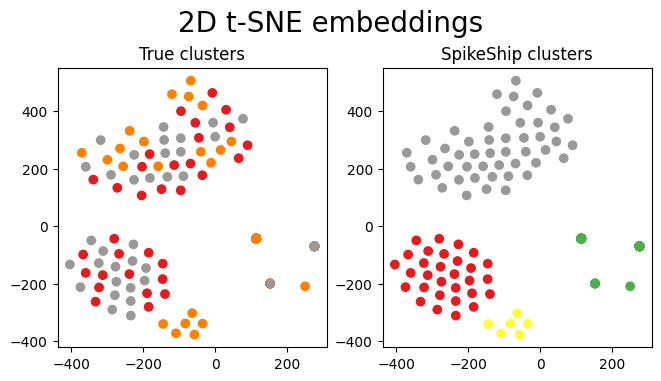

In [ ]:
tPlot,axes = plt.subplots(
    figsize=(6.5,3.7), facecolor='w',nrows=1, ncols=2, sharex=False, sharey=False, constrained_layout=True)

plt.suptitle('2D t-SNE embeddings',fontsize=20)
axes[0].set_title('True clusters')
axes[0].scatter(spikeship_embedding[:, 0], spikeship_embedding[:, 1], cmap='Set1_r', c=epoch_labels)

axes[1].set_title('SpikeShip clusters')
axes[1].scatter(spikeship_embedding[:, 0], spikeship_embedding[:, 1], cmap='Set1_r', c=ss_dis_labels);
